In [1]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
import tensorflow as tf
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np


def visualize_model(title, epoch_max, model_history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1, epoch_max + 1))
    ax1.plot(epoch_list, model_history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, model_history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epoch_max + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, model_history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, model_history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epoch_max + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")


folder_path = r'..\Hand extraction\source_box'
img_height = 200
img_width = 200
batch_size = int(2 ** 7)
EPOCHS = 100

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1000 files belonging to 10 classes.
Using 800 files for training.
Found 1000 files belonging to 10 classes.
Using 200 files for validation.


In [3]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted', 'three', 'three2', 'two_up', 'two_up_inverted']


In [4]:
tf.get_logger().setLevel('ERROR')
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Epoch 1/100
7/7 [==============================] - 40s 5s/step - loss: 2.3738 - accuracy: 0.1075 - val_loss: 2.3678 - val_accuracy: 0.0900
Epoch 2/100
7/7 [==============================] - 26s 4s/step - loss: 2.2573 - accuracy: 0.1538 - val_loss: 2.3342 - val_accuracy: 0.0850
Epoch 3/100
7/7 [==============================] - 26s 4s/step - loss: 2.1563 - accuracy: 0.2025 - val_loss: 2.3125 - val_accuracy: 0.1500
Epoch 4/100
7/7 [==============================] - 26s 4s/step - loss: 2.0841 - accuracy: 0.2587 - val_loss: 2.3117 - val_accuracy: 0.1000
Epoch 5/100
7/7 [==============================] - 26s 4s/step - loss: 1.9996 - accuracy: 0.3150 - val_loss: 2.3006 - val_accuracy: 0.1450
Epoch 6/100
7/7 [==============================] - 25s 3s/step - loss: 1.9072 - accuracy: 0.3300 - val_loss: 2.2877 - val_accuracy: 0.1400
Epoch 7/100
7/7 [==============================] - 25s 4s/step - loss: 1.8156 - accuracy: 0.3862 - val_loss: 2.2831 - val_accuracy: 0.1600
Epoch 8/100
7/7 [==========

ValueError: x and y must have same first dimension, but have shapes (30,) and (100,)

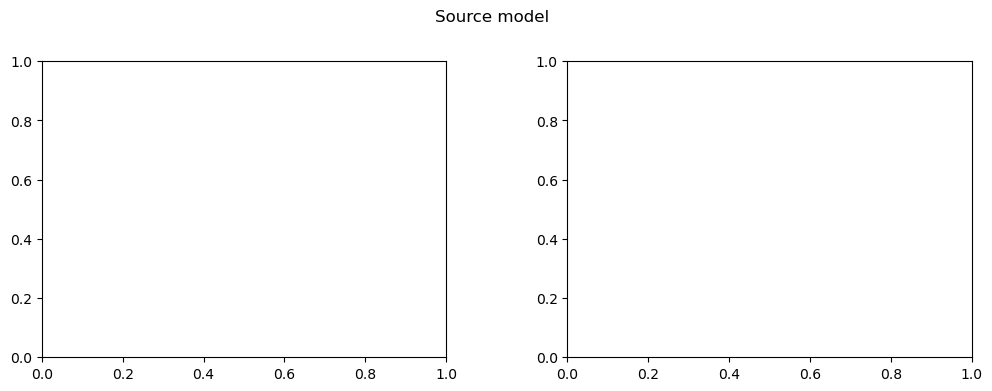

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

source_model = Sequential([data_augmentation,
                        layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
                        Conv2D(16, kernel_size=(3, 3), activation='relu'),
                        MaxPooling2D(pool_size=(2, 2)),
                        BatchNormalization(),
                        Conv2D(64, kernel_size=(3, 3), activation='relu'),
                        MaxPooling2D(pool_size=(2, 2)),
                        Conv2D(128, kernel_size=(3, 3), activation='relu'),
                        MaxPooling2D(pool_size=(2, 2)),
                        Flatten(),
                        Dropout(0.3),
                        Dense(num_classes)])

source_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])

source_history = source_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)
source_model.save('Source model.h5')

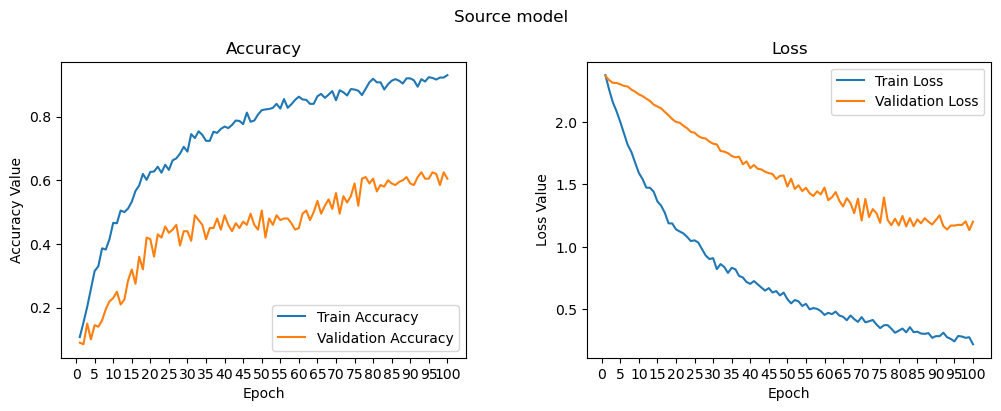

In [6]:
visualize_model('Source model', EPOCHS, source_history)